In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import eotdl

eotdl.__version__

'2024.11.07'

In this notebook we generate the dataset for the use case

1. Generate list of Satellogic images to be used (containing bb and acquisition time)
2. Explore available S1/S2 images with different criteria
	- bounding box overlap
	- acquisition time overlap
3. Download matching S1/S2 at given resolution
4. Generate metadata and ingest to EOTDL 

In [2]:
import geopandas as gpd

gdf = gpd.read_parquet('satellogic-earthview-items.parquet')

gdf.head()

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."


In [3]:
sample = gdf.head(10)
sample

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."
5,data/json/zone=04N/region=603411_2348221/date=...,04N,603411_2348221,2022-09-15,"POLYGON ((-157.99979 21.22915, -157.99977 21.2..."
6,data/json/zone=04N/region=603411_2348605/date=...,04N,603411_2348605,2022-09-15,"POLYGON ((-157.99977 21.23262, -157.99974 21.2..."
7,data/json/zone=04N/region=603795_2346301/date=...,04N,603795_2346301,2022-09-15,"POLYGON ((-157.99621 21.21179, -157.99618 21.2..."
8,data/json/zone=04N/region=603795_2346685/date=...,04N,603795_2346685,2022-09-15,"POLYGON ((-157.99618 21.21525, -157.99616 21.2..."
9,data/json/zone=04N/region=603795_2347069/date=...,04N,603795_2347069,2022-09-15,"POLYGON ((-157.99616 21.21872, -157.99614 21.2..."


Download the images

In [ ]:
import json

for _, item in sample.iterrows():
	json_path = item.json_path
	with open(json_path, 'r') as f:
		metadata = json.load(f)
	asset = metadata['assets']['analytic']['href']
	asset = asset.replace('https://satellogic-earthview.s3.us-west-2.amazonaws.com/', 's3://satellogic-earthview/')
	!s5cmd -endpoint-url https://s3.us-west-2.amazonaws.com --no-sign-request cp {asset} data/tifs/satellogic


cp s3://satellogic-earthview/data/tif/zone=04N/region=603411_2346301/date=2022-09-15/20220915_010014_SN20_04N_603411_2346301_TOA.tif data/tifs/20220915_010014_SN20_04N_603411_2346301_TOA.tif
cp s3://satellogic-earthview/data/tif/zone=04N/region=603411_2346685/date=2022-09-15/20220915_010014_SN20_04N_603411_2346685_TOA.tif data/tifs/20220915_010014_SN20_04N_603411_2346685_TOA.tif
cp s3://satellogic-earthview/data/tif/zone=04N/region=603411_2347069/date=2022-09-15/20220915_010014_SN20_04N_603411_2347069_TOA.tif data/tifs/20220915_010014_SN20_04N_603411_2347069_TOA.tif
cp s3://satellogic-earthview/data/tif/zone=04N/region=603411_2347453/date=2022-09-15/20220915_010014_SN20_04N_603411_2347453_TOA.tif data/tifs/20220915_010014_SN20_04N_603411_2347453_TOA.tif
cp s3://satellogic-earthview/data/tif/zone=04N/region=603411_2347837/date=2022-09-15/20220915_010014_SN20_04N_603411_2347837_TOA.tif data/tifs/20220915_010014_SN20_04N_603411_2347837_TOA.tif
cp s3://satellogic-earthview/data/tif/zone=04

In [12]:
import os

images = os.listdir('data/tifs')
len(images)

10

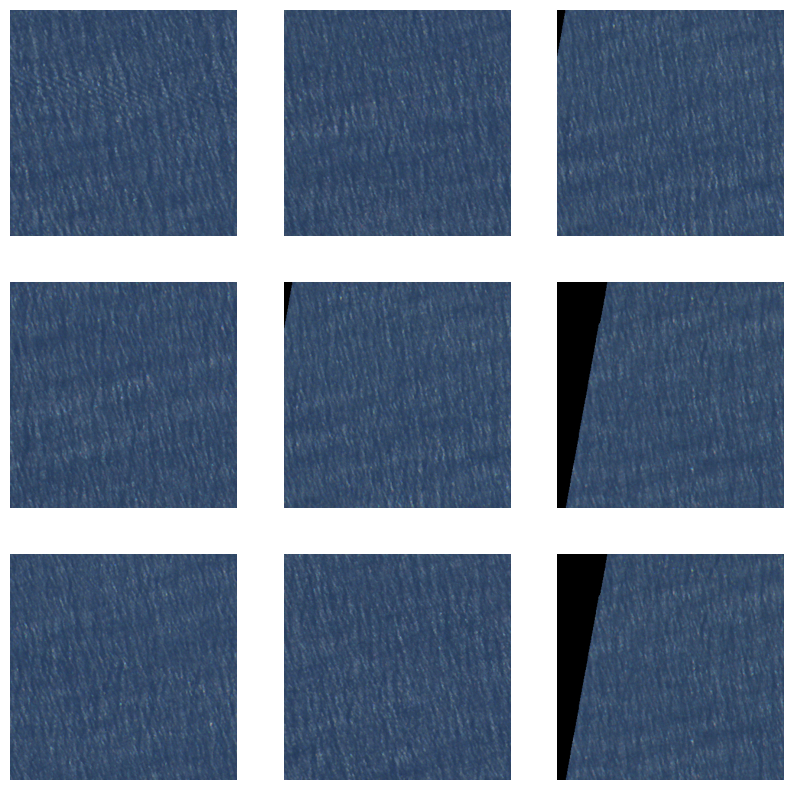

In [29]:
# plot random images

import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
n = 3
fig, axs = plt.subplots(n, n, figsize=(10, 10))
for ax in axs.flatten():
	x = rio.open(f'data/tifs/{np.random.choice(images)}').read()
	ax.imshow(x[:3,...].transpose(1, 2, 0) / 3000)
	ax.axis('off')
plt.show()


In [30]:
x.shape, x.dtype, x.min(), x.max()

((4, 384, 384), dtype('uint16'), np.uint16(0), np.uint16(2271))

In [31]:
from eotdl.access import SUPPORTED_SENSORS

SUPPORTED_SENSORS

('sentinel-1-grd', 'sentinel-2-l1c', 'sentinel-2-l2a', 'dem')

In [15]:
from eotdl.access import search_sentinel_imagery

matches = []
for item in sample:
	dates = item.date
	bb = item.geometry
	r = search_sentinel_imagery(dates, bb, 'sentinel-2-l2a')
	list(r)

NameError: name 'sample' is not defined

TODO: save matching S1 and S2 in data/tifs/S1 and data/tifs/S2; save list of matching S1 and S2 in data/metadata/satellogic.parquet